In [1]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
from functools import reduce
import torch
import networkx as nx
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ast
from transformers import AutoTokenizer, AutoModel
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
import matplotlib.pyplot as plt

2025-05-12 18:41:36.459553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747075296.724554      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747075296.806407      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Предобработка данных

Удалим дублирующиееся новости, заполним пропуски в ссылках на другие источники пустым списком. В качестве тега для новости возьмём только первый тег: разделим строку по символу зяпятой и возьмём первый элемент. Далее отберём новости только с самыми популярными тегами. Если оставить все новости, получится слишком большое количество классов для классификации и для большинства будет слишком мало примеров - модель ничего не выучит

In [3]:
news_df = pd.read_csv("/kaggle/input/graph-news/news.csv", delimiter=";")
news_df.drop_duplicates(subset=["link", "content"], inplace=True)
news_df.fillna({"post_links": "[]"}, inplace=True)
news_df = news_df[~news_df["content"].isna()]
news_df["post_links"] = news_df["post_links"].apply(lambda x: ast.literal_eval(x))
news_df = news_df.fillna({"tags": ""})
news_df["tags"] = news_df["tags"].apply(lambda x: x.split(",")[0])
news_df["tags"] = news_df["tags"].apply(lambda x: "общие новости" if x == "новости" else x)

nodes_classes = news_df["tags"].value_counts()[1:9].keys().tolist()
news_df = news_df[news_df["tags"].isin(nodes_classes)]

# Таргет для задачи

Таргетом в задаче будет являться индекс класса, к которому относится новость (вершина в графе). Ниже создаются словари для кодирования тегов новостей в таргет и обратно

In [4]:
n_classes = len(nodes_classes)
class2target = {class_name:target for target, class_name in enumerate(nodes_classes)}
target2class = {target:class_name for class_name, target in class2target.items()}

In [47]:
news_df["tags"].value_counts()

tags
общие новости                      906
Энергетика                         710
Финансовый сектор                  571
Потребительские товары и услуги    477
Информационные технологии          451
Сырьевая промышленность            248
Машиностроение и транспорт         193
Происшествия                        74
Name: count, dtype: int64

# В ссылках на источники оставим только те, которые есть в датасете

In [5]:
news_nodes = {}
for _, row in news_df.iterrows():
    news_nodes[row["link"]] = 1

news_df["post_links"] = news_df["post_links"].apply(lambda x: [link for link in x if link in news_nodes])

# Число рёбер и число вершин в графе

In [6]:
cnt = 0
for _, row in news_df.iterrows():
    cnt += len(row["post_links"])
cnt, news_df.shape[0]

(311, 3630)

# Создадим граф из наших данных

Каждую вершину в графе представим в виде вектора - выхода из bert-like модели для русского языка. Можно один раз закодировать вершины и далее использовать как признаки вершин

In [6]:
def encode_texts(texts, batch_size=512):
    tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
    model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="text encoding"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        embeddings.append(batch_embeddings)
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

Для применения графовых нейросеть необходимо создать список рёбер графа. Рёбра идут от новостей к другим новостям, которые упоминались в первой. Отдельно создадим список вершин от которых идут рёбра и отдельно список вершин, к которым рёбра ведут. Для каждой вершине назначаетс свой уникальный id

In [7]:
def create_edge_index(df):
    link2id = {link:ID for ID, link in enumerate(df["link"].tolist())}
    id2link = {ID:link for link, ID in link2id.items()}
    from_nodes = [[link2id[row["link"]]] * len(row["post_links"]) for _, row in df.iterrows() if len(row["post_links"]) > 0]
    from_nodes = reduce(lambda x, y: x + y, from_nodes)
    to_nodes = [[link2id[node] for node in row["post_links"]] for _, row in df.iterrows() if len(row["post_links"]) > 0]
    to_nodes = reduce(lambda x, y: x + y, to_nodes)
    edge_index = torch.tensor([from_nodes, to_nodes])
    return edge_index, link2id, id2link

In [8]:
embeddings = encode_texts(news_df["content"].tolist(), batch_size=128)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

text encoding: 100%|██████████| 29/29 [00:35<00:00,  1.22s/it]


In [9]:
embeddings_tensors = torch.tensor(embeddings)
target = torch.tensor([class2target[tag] for tag in news_df["tags"].tolist()])

In [62]:
target.shape

torch.Size([3630])

# Разбиение данных для обучения и валидации модели

Для нашей задачи разделим вершины на три части: на обучающие данные, которые будет участвовать в подсчёте функции потерь и будут влиять на параметры модели, валидационные - за которыми мы будем следить во время обучения, и тестовые - нужны для финального тестирования модели. Для выбора тех или иных данных создадим маску - какие вершины к какой части данных относятся

In [10]:
num_nodes = target.shape[0]
train_idx, val_test_idx = train_test_split(range(num_nodes), random_state=42, train_size=0.8)
val_idx, test_idx = train_test_split(val_test_idx, random_state=42, train_size=0.5)

In [11]:
edge_index, link2id, id2link = create_edge_index(news_df)

In [12]:
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Создание объекта графа Data

Здесь создаётся объект типа Data, который является графом новостей. x - признаки вершин размера 312, y - номер класса новости, edge_index - список рёбер графа

In [13]:
data = Data(x=embeddings_tensors, y=target, edge_index=edge_index)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [16]:
data.train_mask.sum(), data.val_mask.sum(), data.test_mask.sum()

(tensor(2904), tensor(363), tensor(363))

# DL beseline

В качестве бейзлайна была выбрана просто линейная сеть, которая пытается предсказать класс новости, используя только саму эту новость

In [14]:
class SimpleNodeClassificationModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes):
        super().__init__()
        torch.manual_seed(42)
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.lin3 = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.lin3(self.relu(self.lin2(self.relu(self.lin1(x)))))
        return x

# GCN модель

В качестве более сильной модели была выбрана графовая нейронная сеть, которая для предсказания класса новости использует её соседей. Сначала ембеддинги вершин пересчитываются с помощью слоёв графовой свертки, далее прогоняются через линейные слои для получения предсказания класса

In [15]:
class GCNNodeClassificationModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, conv_type="gcn", num_conv_layers=1):
        super().__init__()
        torch.manual_seed(42)
        if conv_type == "gcn":
            conv_layers = [GCNConv(input_dim, hidden_dim)]
            if num_conv_layers > 1:
                for i in range(num_conv_layers - 1):
                    conv_layers.append(GCNConv(hidden_dim, hidden_dim))
        else: # using GAT
            conv_layers = [GATConv(input_dim, hidden_dim)]
            if num_conv_layers > 1:
                for i in range(num_conv_layers - 1):
                    conv_layers.append(GATConv(hidden_dim, hidden_dim))
        self.conv_layers = conv_layers
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.lin3 = nn.Linear(hidden_dim, n_classes)

    def forward(self, x, edge_index):
        for layer in self.conv_layers:
            x = layer(x, edge_index)
            x = self.tanh(x)
        x = self.lin3(self.relu(self.lin2(self.relu(self.lin1(x)))))
        return x

# Обучение и валидация бейзлайна

In [16]:
simple_model = SimpleNodeClassificationModel(312, 312, n_classes)
optimizer = torch.optim.Adam(simple_model.parameters())
criterion = nn.CrossEntropyLoss()

In [17]:
def train(data, model, epochs=100, edge_index=None):
    train_history = []
    train_acc_history = []
    val_history = []
    val_acc_history = []
    for epoch in range(epochs):
        if edge_index:
            logits = model(data.x, data.edge_index)
        else:
            logits = model(data.x)
        preds = torch.argmax(logits, dim=-1)
        loss = criterion(logits[data.train_mask], data.y[data.train_mask])
        train_history.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        preds = torch.argmax(logits[data.train_mask], dim=-1).detach().cpu().numpy()
        target = data.y[data.train_mask].detach().cpu().numpy()
        acc = accuracy_score(target, preds)
        train_acc_history.append(acc)
        with torch.no_grad():
            if edge_index:
                logits = model(data.x, data.edge_index)
            else:
                logits = model(data.x)
            loss = criterion(logits[data.val_mask], data.y[data.val_mask])
            val_history.append(loss.item())
            preds = torch.argmax(logits[data.val_mask], dim=-1).detach().cpu().numpy()
            target = data.y[data.val_mask].detach().cpu().numpy()
            acc = accuracy_score(target, preds)
            val_acc_history.append(acc)
    return train_history, train_acc_history, val_history, val_acc_history

def test(data, model, edge_index=None):
    with torch.no_grad():
        if edge_index:
            logits = model(data.x, data.edge_index)
        else:
            logits = model(data.x)
        preds = torch.argmax(logits[data.test_mask], dim=-1).detach().cpu().numpy()
        target = data.y[data.test_mask].detach().cpu().numpy()
        acc = accuracy_score(target, preds)
    return acc

def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("accuracy")
    plt.show()

In [19]:
train_history, train_acc_history, val_history, val_acc_history = train(data, simple_model)

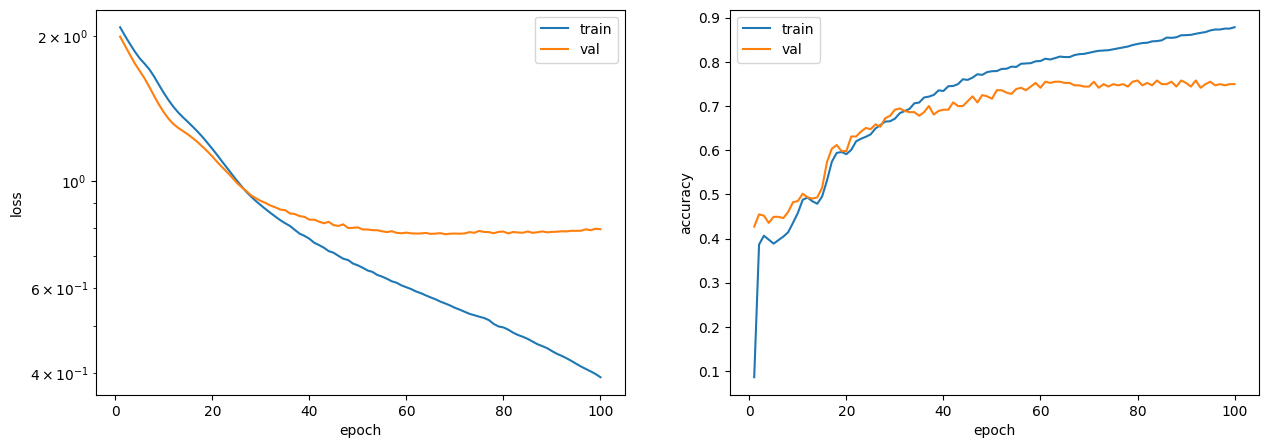

In [20]:
plot_losses(train_history, train_acc_history, val_history, val_acc_history)

In [21]:
print("test baseline acc: ", test(data, simple_model))

test baseline acc:  0.7410468319559229


# Графовая нейросеть

In [22]:
model = GCNNodeClassificationModel(312, 312, n_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [23]:
train_history, train_acc_history, val_history, val_acc_history = train(data, model, edge_index=True)

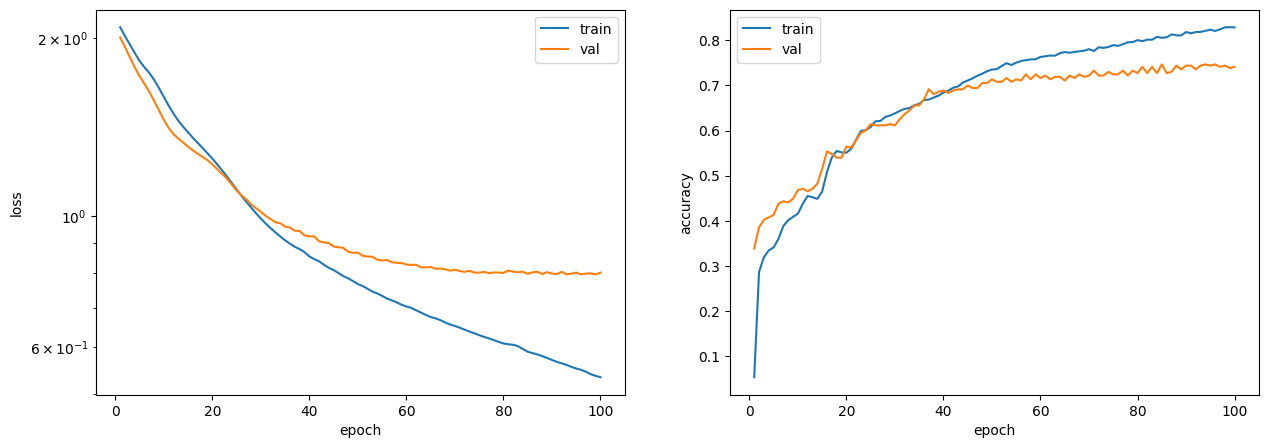

In [24]:
plot_losses(train_history, train_acc_history, val_history, val_acc_history)

In [25]:
print("GCN test accuracy: ", test(data, model, edge_index=True))

GCN test accuracy:  0.7134986225895317


# Заменим слой свёртки на GAT

In [26]:
gat_model = GCNNodeClassificationModel(312, 312, n_classes, conv_type="GAT")
optimizer = torch.optim.Adam(gat_model.parameters())
criterion = nn.CrossEntropyLoss()

In [27]:
train_history, train_acc_history, val_history, val_acc_history = train(data, gat_model, edge_index=True)

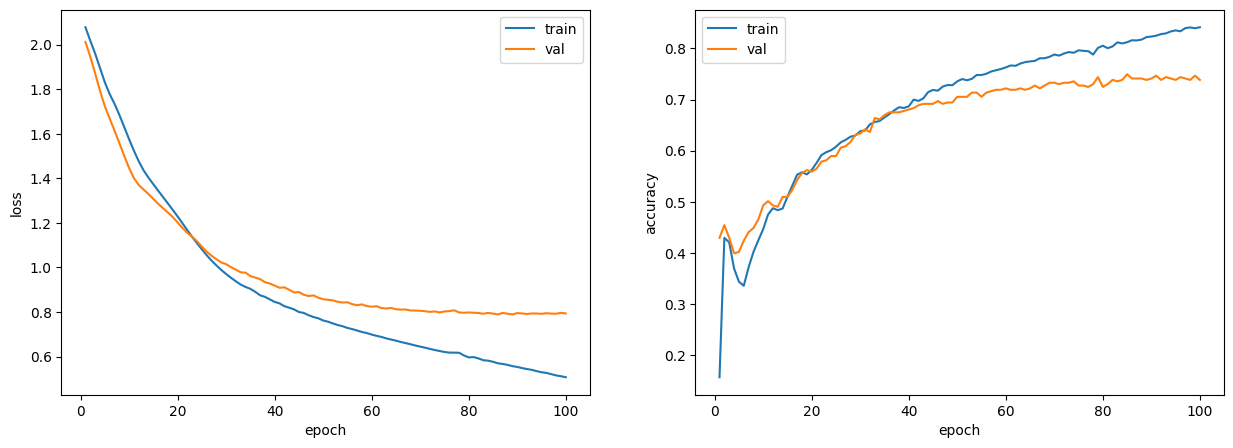

In [28]:
plot_losses(train_history, train_acc_history, val_history, val_acc_history)

In [29]:
print("GAT test accuracy: ", test(data, gat_model, edge_index=True))

GAT test accuracy:  0.7272727272727273
